In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load the dataset
# Replace 'your_dataset.csv' with the actual file path
# Since the dataset columns have issues with spaces and formatting, we'll read it with specific parameters
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv'
df = pd.read_csv(url)
df


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through","This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [ ]:
# Basic preprocessing
# Drop unnecessary columns and handle NaN values
df = df.dropna(subset=['Review Text', 'Rating'])


In [ ]:
# Convert ratings to binary sentiment (1-3 as negative, 4-5 as positive)
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)


<ipython-input-46-f6b8a9553560>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x >= 4 else 0)


In [ ]:
# Text preprocessing function
def preprocess_text(text):
    """Clean and preprocess the text data"""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f'[{string.punctuation}]', ' ', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text


In [ ]:
# Apply preprocessing to review text
df['Processed_Text'] = df['Review Text'].apply(preprocess_text)


<ipython-input-48-287461538c48>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Processed_Text'] = df['Review Text'].apply(preprocess_text)


In [ ]:
# Display class distribution
print("Sentiment distribution:")
print(df['Sentiment'].value_counts(normalize=True) * 100)

Sentiment distribution:
Sentiment
1    77.063734
0    22.936266
Name: proportion, dtype: float64


In [ ]:
# Split the data into training and testing sets
X = df['Processed_Text'].values
y = df['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Tokenize the text data
max_words = 15000
max_len = 250

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)


In [ ]:
# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [ ]:
# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [ ]:
# Calculate vocabulary size after tokenization
vocab_size = min(len(tokenizer.word_index) + 1, max_words)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 12375


In [ ]:
model = Sequential([
    # Embedding layer with more dimensions
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),

    # SpatialDropout1D helps prevent overfitting in the embedding layer
    SpatialDropout1D(0.3),  # Increased dropout

    # Bidirectional LSTM layer
    Bidirectional(LSTM(lstm_units, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)),

    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(lstm_units, dropout=0.25, recurrent_dropout=0.25)),

    # Dropout to prevent overfitting
    Dropout(0.3),

    # Dense layer with more neurons
    Dense(64, activation='relu'),

    # Another dropout layer
    Dropout(0.25),

    # Output layer with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Custom learning rate for Adam optimizer
optimizer = Adam(learning_rate=0.001)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks for better training
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0001,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


In [ ]:
# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,  # Fixed at 10 epochs
    batch_size=64,
    callbacks=[early_stop, reduce_lr, model_checkpoint]
)


Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7861 - loss: 0.4895
Epoch 1: val_accuracy improved from -inf to 0.86558, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 779s 3s/step - accuracy: 0.7862 - loss: 0.4892 - val_accuracy: 0.8656 - val_loss: 0.2997 - learning_rate: 0.0010
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8662 - loss: 0.3138
Epoch 2: val_accuracy did not improve from 0.86558
227/227 ━━━━━━━━━━━━━━━━━━━━ 709s 3s/step - accuracy: 0.8662 - loss: 0.3138 - val_accuracy: 0.8623 - val_loss: 0.3120 - learning_rate: 0.0010
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8814 - loss: 0.2932
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 3: val_accuracy did not improve from 0.86558
227/227 ━━━━━━━━━━━━━━━━━━━━ 751s 3s/step - accuracy: 0.8814 - loss: 0.2932 - val_accuracy: 0.8427 - val_loss: 0.3673 - learning_rate: 0.0010
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8918 - loss: 0.2734
Epoch 4: val_accuracy improved from 0.86558 to 0.87441, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 707s 3s/step - accuracy: 0.8918 - loss: 0.2735 - val_accuracy: 0.8744 - val_loss: 0.2989 - learning_rate: 5.0000e-04
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8958 - loss: 0.2509
Epoch 5: val_accuracy improved from 0.87441 to 0.88490, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 733s 3s/step - accuracy: 0.8958 - loss: 0.2508 - val_accuracy: 0.8849 - val_loss: 0.3016 - learning_rate: 5.0000e-04
Epoch 6/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9117 - loss: 0.2268
Epoch 6: val_accuracy improved from 0.88490 to 0.88518, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 741s 3s/step - accuracy: 0.9117 - loss: 0.2268 - val_accuracy: 0.8852 - val_loss: 0.2854 - learning_rate: 5.0000e-04
Epoch 7/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9197 - loss: 0.2080
Epoch 7: val_accuracy did not improve from 0.88518
227/227 ━━━━━━━━━━━━━━━━━━━━ 736s 3s/step - accuracy: 0.9197 - loss: 0.2080 - val_accuracy: 0.8835 - val_loss: 0.2978 - learning_rate: 5.0000e-04
Epoch 8/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9264 - loss: 0.1972
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 8: val_accuracy improved from 0.88518 to 0.88794, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 748s 3s/step - accuracy: 0.9264 - loss: 0.1972 - val_accuracy: 0.8879 - val_loss: 0.3093 - learning_rate: 5.0000e-04
Epoch 9/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9331 - loss: 0.1813
Epoch 9: val_accuracy did not improve from 0.88794
227/227 ━━━━━━━━━━━━━━━━━━━━ 730s 3s/step - accuracy: 0.9331 - loss: 0.1813 - val_accuracy: 0.8808 - val_loss: 0.3006 - learning_rate: 2.5000e-04
Epoch 10/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9386 - loss: 0.1710
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 10: val_accuracy did not improve from 0.88794
227/227 ━━━━━━━━━━━━━━━━━━━━ 778s 3s/step - accuracy: 0.9386 - loss: 0.1710 - val_accuracy: 0.8794 - val_loss: 0.2945 - learning_rate: 2.5000e-04


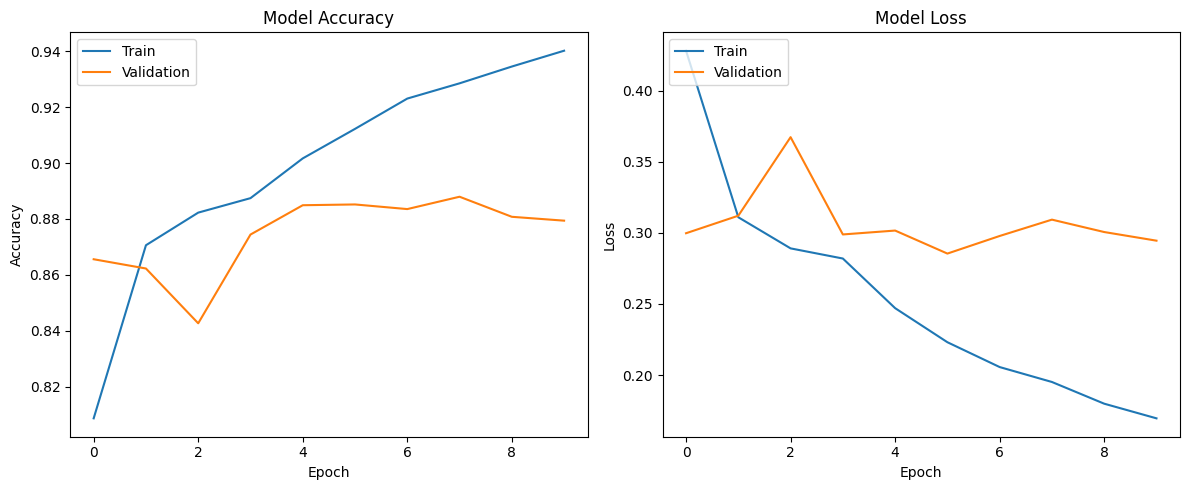

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model saved during training
model = load_model('best_model.h5')

In [ ]:
# Evaluate the model on test data
y_pred_proba = model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()


142/142 ━━━━━━━━━━━━━━━━━━━━ 76s 525ms/step


In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)


In [ ]:
# Print evaluation metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC: {auc:.4f}")


Test Accuracy: 0.8768
Test Precision: 0.8988
Test Recall: 0.9467
Test F1 Score: 0.9221
Test AUC: 0.9224


In [ ]:
# Calculate training metrics
y_train_pred_proba = model.predict(X_train_pad)
y_train_pred = (y_train_pred_proba > 0.5).astype(int).flatten()
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")


566/566 ━━━━━━━━━━━━━━━━━━━━ 289s 510ms/step
Training Accuracy: 0.9308


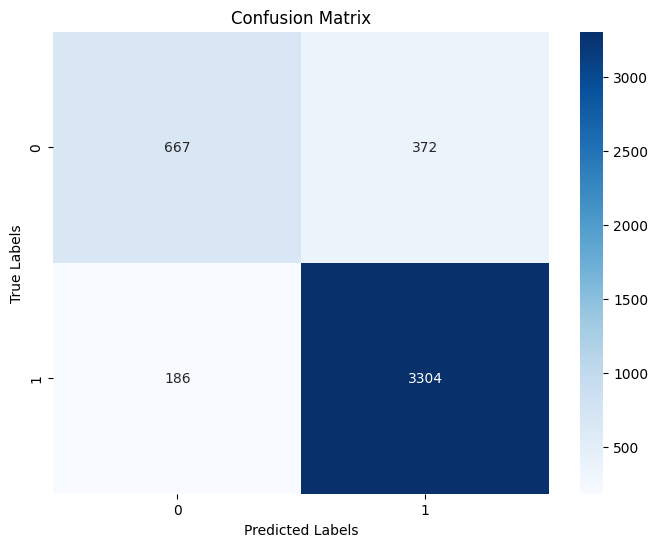

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


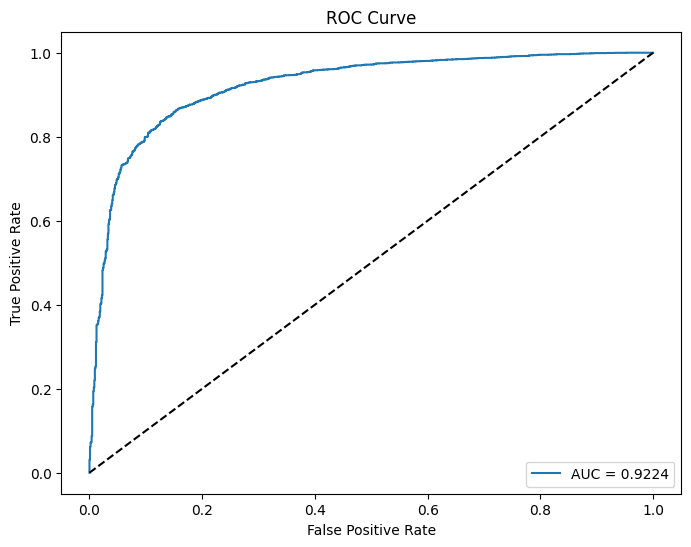

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#Save the model and tokenizer for future use
model.save('sentiment_lstm_model_tf.h5')
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!


In [ ]:
# Example of how to use the model for inference
def predict_sentiment(review_text, model, tokenizer, max_len=250):
    """
    Predict sentiment for a given review text using the trained model

    Parameters:
    review_text (str): The text of the review
    model: Trained TensorFlow model
    tokenizer: Fitted tokenizer
    max_len (int): Maximum sequence length

    Returns:
    float: Predicted sentiment score (0-1)
    str: Sentiment label ('Negative' or 'Positive')
    """
    # Preprocess the text
    processed_text = preprocess_text(review_text)

    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed_text])

    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Make prediction
    prediction = model.predict(padded_sequence)[0][0]

    # Return prediction score and label
    sentiment_label = 'Positive' if prediction >= 0.5 else 'Negative'
    return prediction, sentiment_label

In [ ]:
# Example usage
example_reviews = [
    "This dress is beautiful and fits perfectly! The material is high quality and the color is exactly as shown.",
    "I'm disappointed with this purchase. The fabric is thin and it ripped after one wash.",
    "The product is okay, not great but not terrible either. I expected better quality for the price."
]

print("\nExample Model Usage:")
print("=====================")

for i, review in enumerate(example_reviews):
    score, label = predict_sentiment(review, model, tokenizer)
    print(f"\nExample {i+1}:")
    print(f"Review: {review}")
    print(f"Sentiment Score: {score:.4f}")
    print(f"Sentiment: {label}")



Example Model Usage:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step

Example 1:
Review: This dress is beautiful and fits perfectly! The material is high quality and the color is exactly as shown.
Sentiment Score: 0.9929
Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step

Example 2:
Review: I'm disappointed with this purchase. The fabric is thin and it ripped after one wash.
Sentiment Score: 0.0469
Sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step

Example 3:
Review: The product is okay, not great but not terrible either. I expected better quality for the price.
Sentiment Score: 0.0468
Sentiment: Negative
